# Exploring SWED - sentinel-2 waters edge dataset

# Imports and fucntions

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from osgeo import gdal

import os
import glob
import random

In [2]:
#Functions for loading data
def channel_filter(img,c=0):
    """Returns given channel from image"""
    img = np.array(img)
    c_img = img[:, :, c]

    return c_img

def get_rgb(img):
    """Return normalized RGB channels from sentinal image"""
    
    rgb_img = img[:, :, [3,2,1]]
    rgb_normalize = np.clip(rgb_img/10000, 0, 0.3)/0.3
    
    return rgb_normalize

def load_train(path):
    """Returns sentinal image, rgb image and label"""
    
    label_path = path.replace("images","labels").replace("image","chip")
   
    img = np.load(path)
    rgb_img = get_rgb(img)
    label = np.load(label_path)[0]
    
    return img, rgb_img, label


def load_test(path):
    """Returns sentinal image, rgb image and label"""
    
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)
    rgb_img = get_rgb(stack_img)
    
    label_path = path.replace("images","labels").replace("image","label")
    label = gdal.Open(label_path).ReadAsArray()
    
    return stack_img, rgb_img, label

#Functions for plotting data
def plot_channels(img):
    
    """Plot all channels of a given image"""
    
    channels = ['Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2']

    fig, axs = plt.subplots(3,4,figsize=(15,10))
    fig.patch.set_facecolor('xkcd:white')

    index = 0
    for i in range(3):
        for j in range(4):
            c_img = channel_filter(img,c=index)

            axs[i,j].imshow(c_img,cmap='gray')
            axs[i,j].set_title(channels[index])
            axs[i,j].axis("off")

            index +=1

def plot_label(path):
    """Diplays RGB image and label"""
    
    if 'train' in path: 
        img, rgb_img, label = load_train(path)
    elif 'test' in path: 
        img, rgb_img, label = load_test(path)

    #Display
    fig,axs = plt.subplots(1,2,figsize=(15,15))
    fig.patch.set_facecolor('xkcd:white')

    axs[0].imshow(rgb_img)
    axs[0].axis("off")
    
    axs[1].imshow(label,cmap="BrBG")
    axs[1].axis("off")

def band_histogram(img):
    """Plots histogram of all bands in image"""

    channels = ['Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2']
    
    fig, axs = plt.subplots(3,4,figsize=(15,10))
    fig.patch.set_facecolor('xkcd:white')

    index = 0
    for i in range(3):
        for j in range(4):
            c_img = channel_filter(img,c=index)

            axs[i,j].hist(c_img.ravel(), fc='k', ec='k')
            axs[i,j].set_title(channels[index])

            index +=1

# Training dataset

## Meta data

In [3]:
# Load input paths
train_input = glob.glob("../data/SWED/train/images/*")

print(train_input[0])
print(len(train_input))

#Load first image
img = np.load(train_input[0])
np.shape(img)


../data/SWED/train/images/S2B_MSIL2A_20200207T113309_N0214_R080_T28PCA_20200207T132518_image_22_12.npy
28224


(256, 256, 12)

In [4]:
# Load label paths
train_label = glob.glob("../data/SWED/train/labels/*")
print(train_label[0])
len(train_label)

#Load first label
label = np.load(train_label[0])
np.shape(label)

../data/SWED/train/labels/S2A_MSIL2A_20170409T105651_N0204_R094_T30UYC_20170409T110529_chip_26_17.npy


(1, 256, 256)

In [5]:
# Confirm all images are Level-2A product level
for path in train_input:
    product_level = path.split("_")[1]
    if product_level != 'MSIL2A':
        print(path)

In [6]:
# Confirm that ever input has a label
no_label = []
for path in train_input:
   
    label = path.replace("images","labels").replace("image","chip")
    if label not in train_label:
        no_label.append(label)
        
print(len(no_label))

0


In [7]:
# Confirm all images have 12 channels
n_channels = []
for path in train_input:
    
    img = np.load(path)
    
    shape = np.shape(img)
    n_channels.append(shape[2])
    
print(min(n_channels), max(n_channels))

12 12


### Display images

../data/SWED/train/images/S2A_MSIL2A_20171120T101321_N0206_R022_T32TQR_20171120T122503_image_5_7.npy


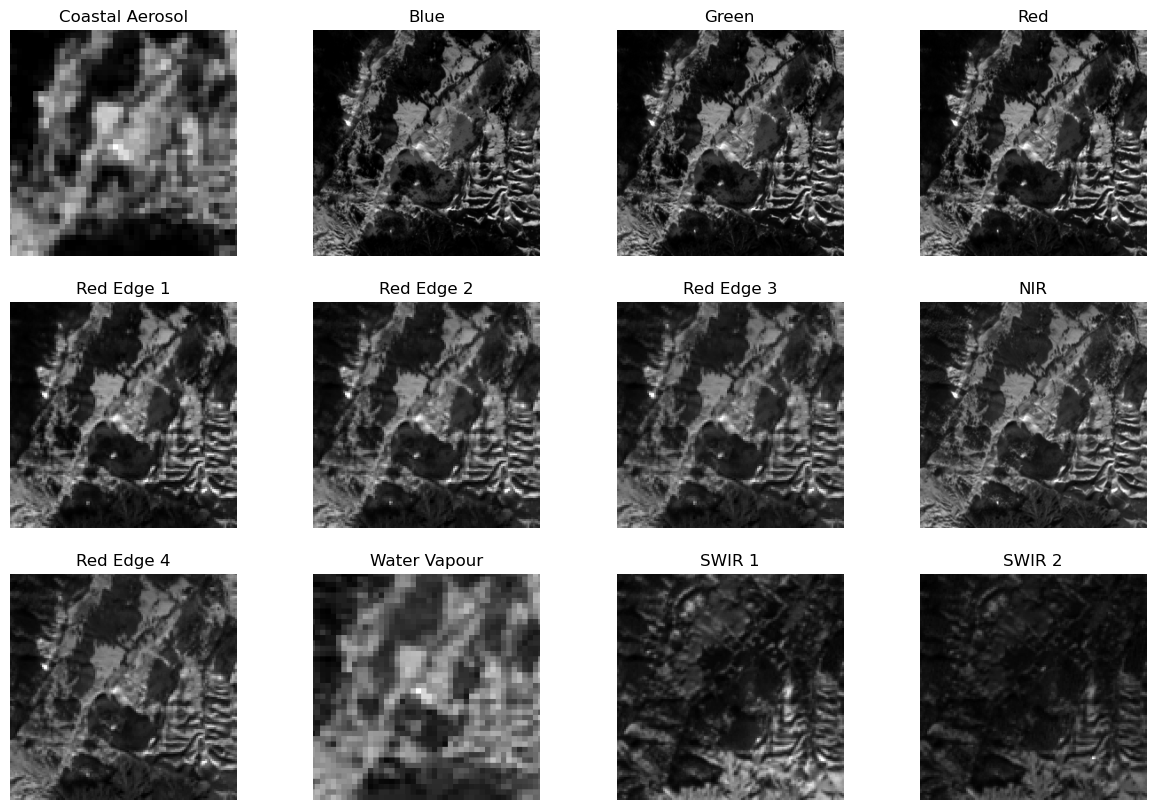

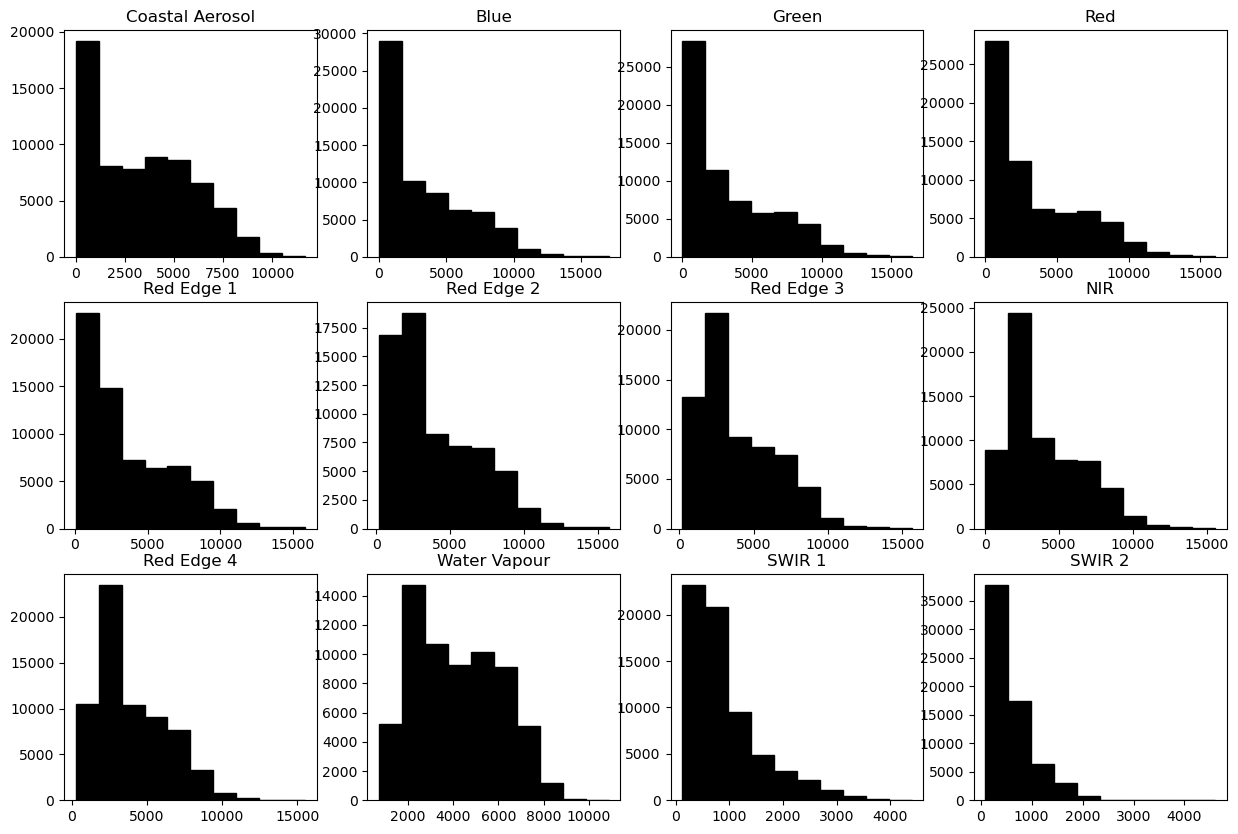

In [8]:
#Display channels from a random training image
rint = random.randint(0, len(train_input))
path = train_input[rint]
print(path)

img = np.load(path)
plot_channels(img)

band_histogram(img)

(-0.5, 255.5, 255.5, -0.5)

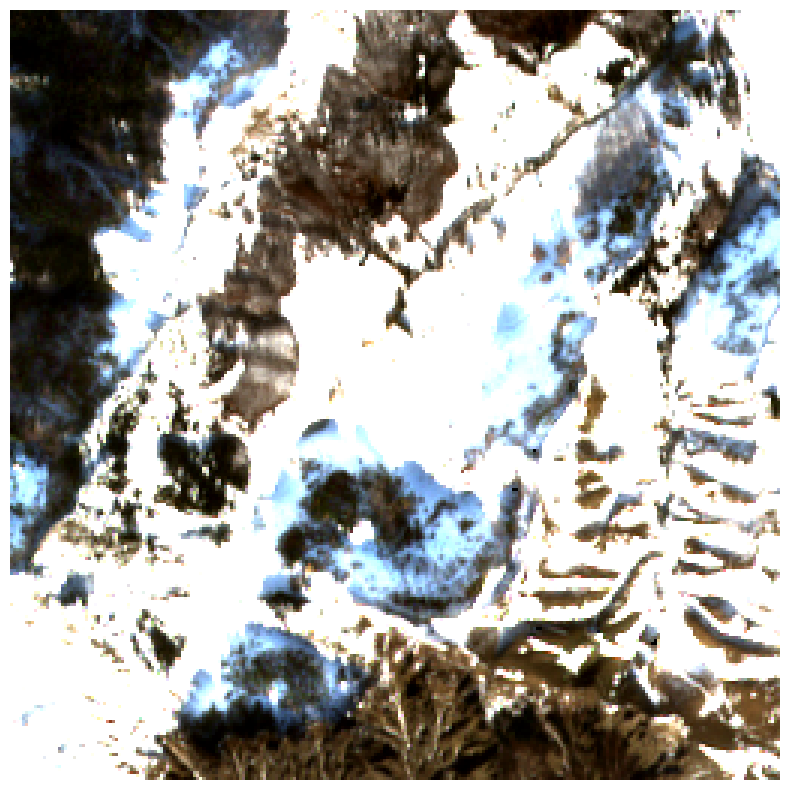

In [9]:
#Display combined rgb channels from a random training image
rgb_img = get_rgb(img)

fig = plt.figure(figsize=(10,10))
plt.imshow(rgb_img)
plt.axis("off")

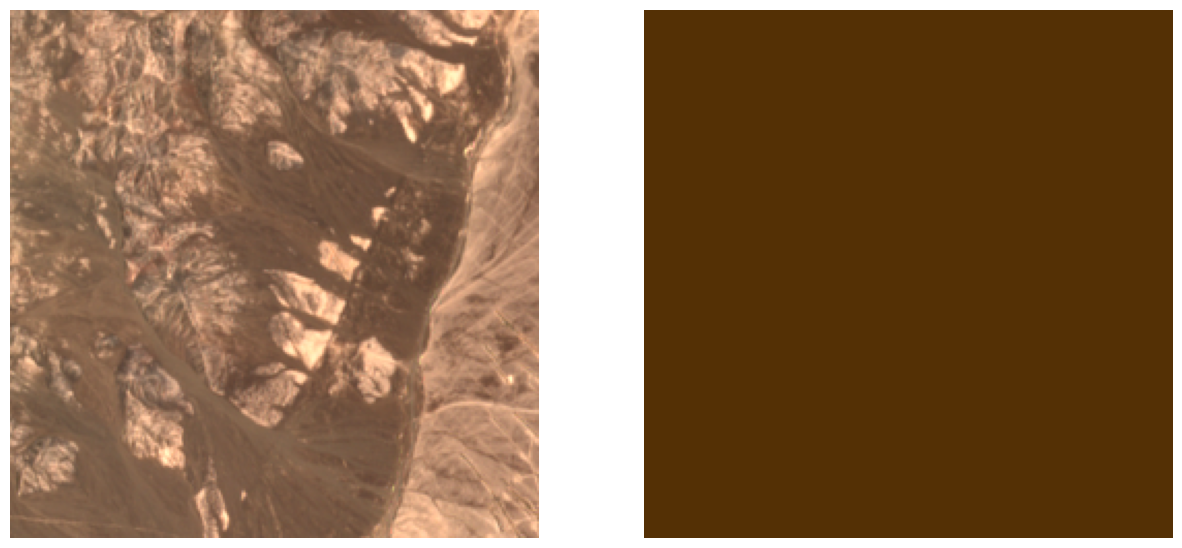

In [15]:
#Display rgb image and label from a random training image
rint = random.randint(0, len(train_input))
path = train_input[rint]

plot_label(path)

## Data quality 

0 0


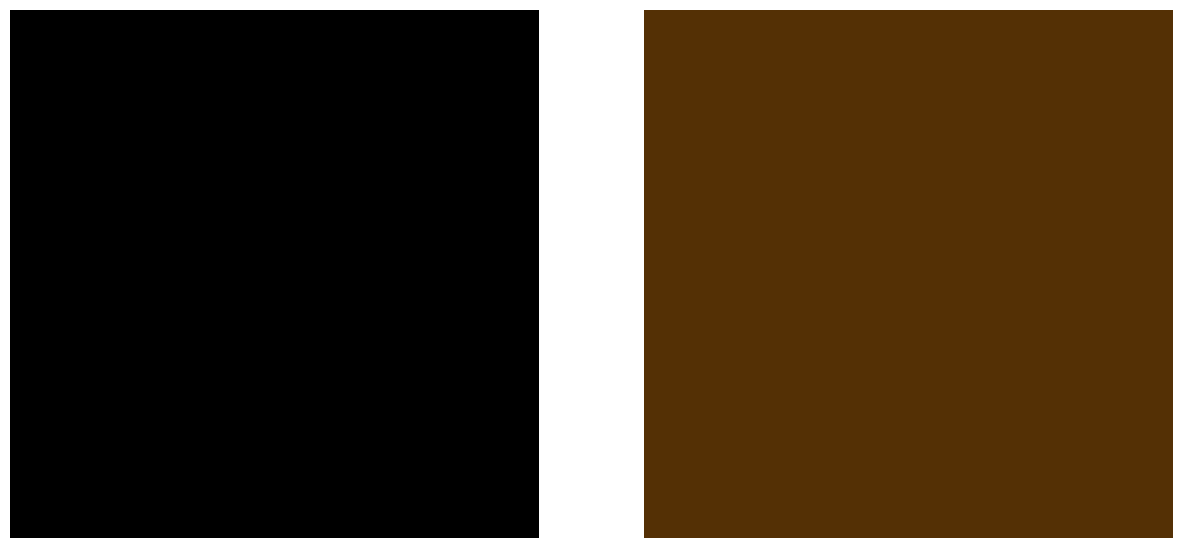

In [19]:
#Example of blank image
path = "../data/SWED/train/images/S2A_MSIL2A_20190718T230911_N0213_R101_T58KDB_20190719T005046_image_1_2.npy"
plot_label(path)

#Image will only contain pixels with value 0
img = np.load(path)
max_value = np.max(img)
min_value = np.min(img)
print(min_value, max_value)

In [20]:
# Find all blank images
no_data = []
for path in train_input:
    img = np.load(path)
    max_value = np.max(img)
    min_value = np.min(img)
    
    if max_value == min_value == 0:
        no_data.append(path)
    
print(len(no_data))
print(len(no_data)*1.00/len(train_input))

2430
0.08609693877551021


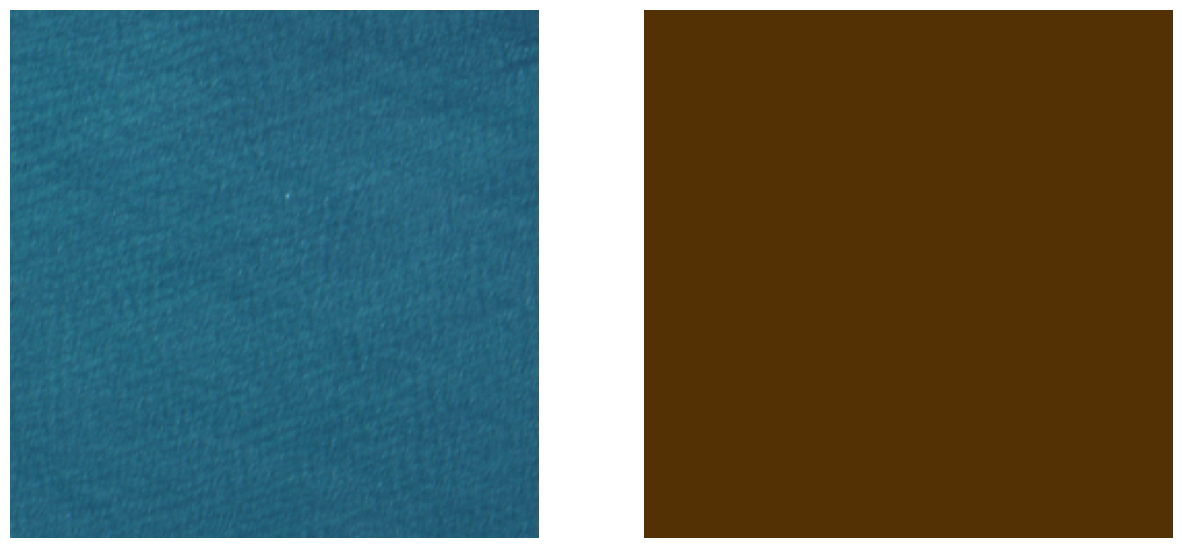

In [21]:
#Examples of water images
water_images = [
"../data/SWED/train/images/S2A_MSIL2A_20200206T144701_N0214_R139_T19KCQ_20200206T185550_image_7_0.npy",
"../data/SWED/train/images/S2A_MSIL2A_20190331T155221_N0211_R111_T17MNT_20190331T224544_image_24_5.npy",
"../data/SWED/train/images/S2A_MSIL2A_20171120T101321_N0206_R022_T32TQR_20171120T122503_image_31_40.npy",
"../data/SWED/train/images/S2A_MSIL2A_20191222T125301_N0213_R052_T24MXV_20191222T144240_image_1_39.npy"]

plot_label(water_images[3])

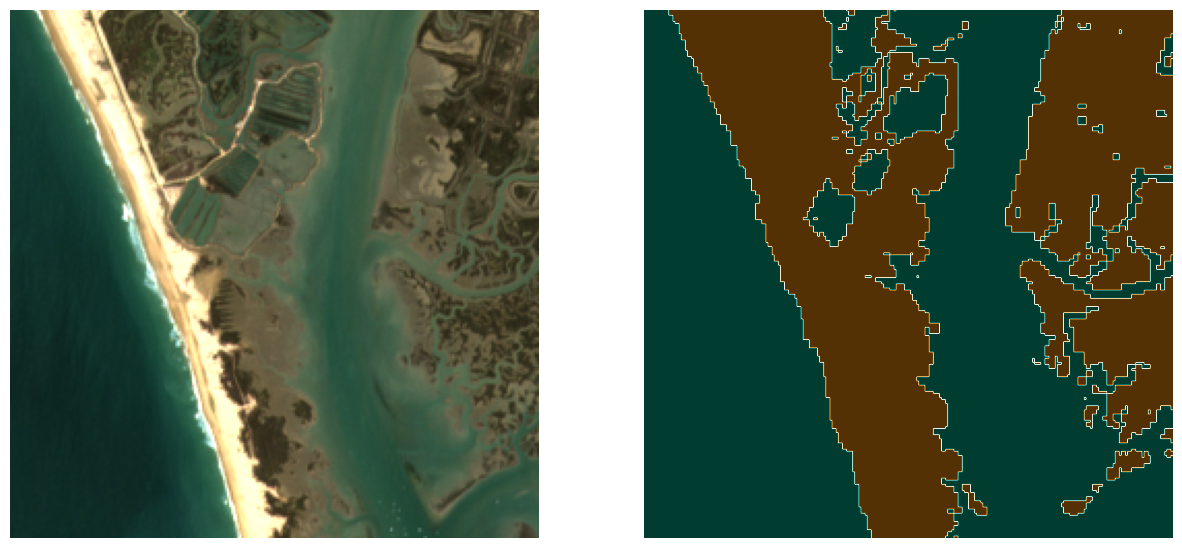

In [22]:
# Examples of imperfect labels
examples = [
"../data/SWED/train/images/S2A_MSIL2A_20171120T101321_N0206_R022_T32TQR_20171120T122503_image_37_24.npy",
"../data/SWED/train/images/S2A_MSIL2A_20190331T155221_N0211_R111_T17MNT_20190331T224544_image_15_7.npy",
"../data/SWED/train/images/S2A_MSIL2A_20190929T110841_N0208_R137_T30STF_20190929T114915_image_8_34.npy",
"../data/SWED/train/images/S2A_MSIL2A_20190929T110841_N0208_R137_T30STF_20190929T114915_image_25_4.npy"]

plot_label(examples[3])

# Test set 

In [23]:
test_input = glob.glob("../data/SWED/test/images/*")
print(test_input[0])
len(test_input)

../data/SWED/test/images/S2A_MSIL2A_20200107T175721_N0213_R141_T12QVM_20200107T214721_image_0_0.tif


98

In [24]:
test_labels = glob.glob("../data/SWED/test/labels/*")
print(test_labels[0])
len(test_labels)

../data/SWED/test/labels/S2A_MSIL2A_20200215T082021_N0214_R121_T36SXA_20200215T110825_label_0_0.tif


98

../data/SWED/test/images/S2B_MSIL2A_20190226T111049_N0211_R137_T31UCT_20190226T172349_image_0_1.tif


/usr/lib/python3/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


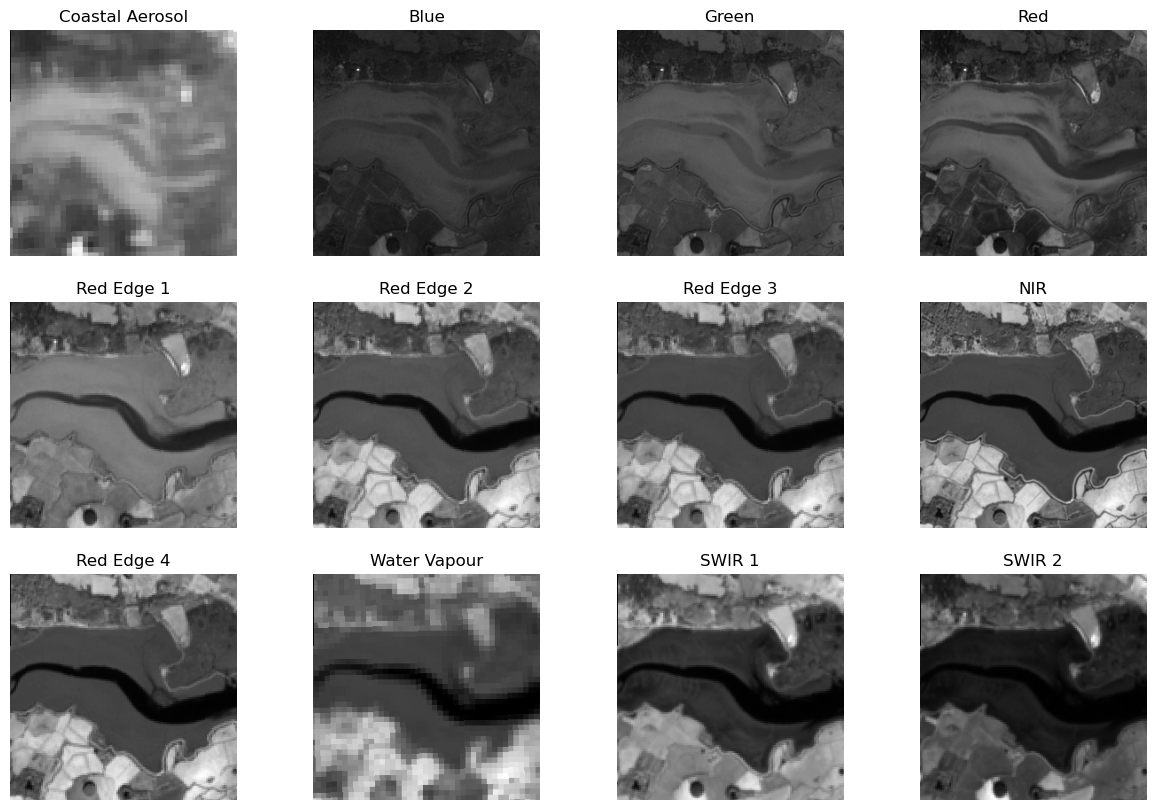

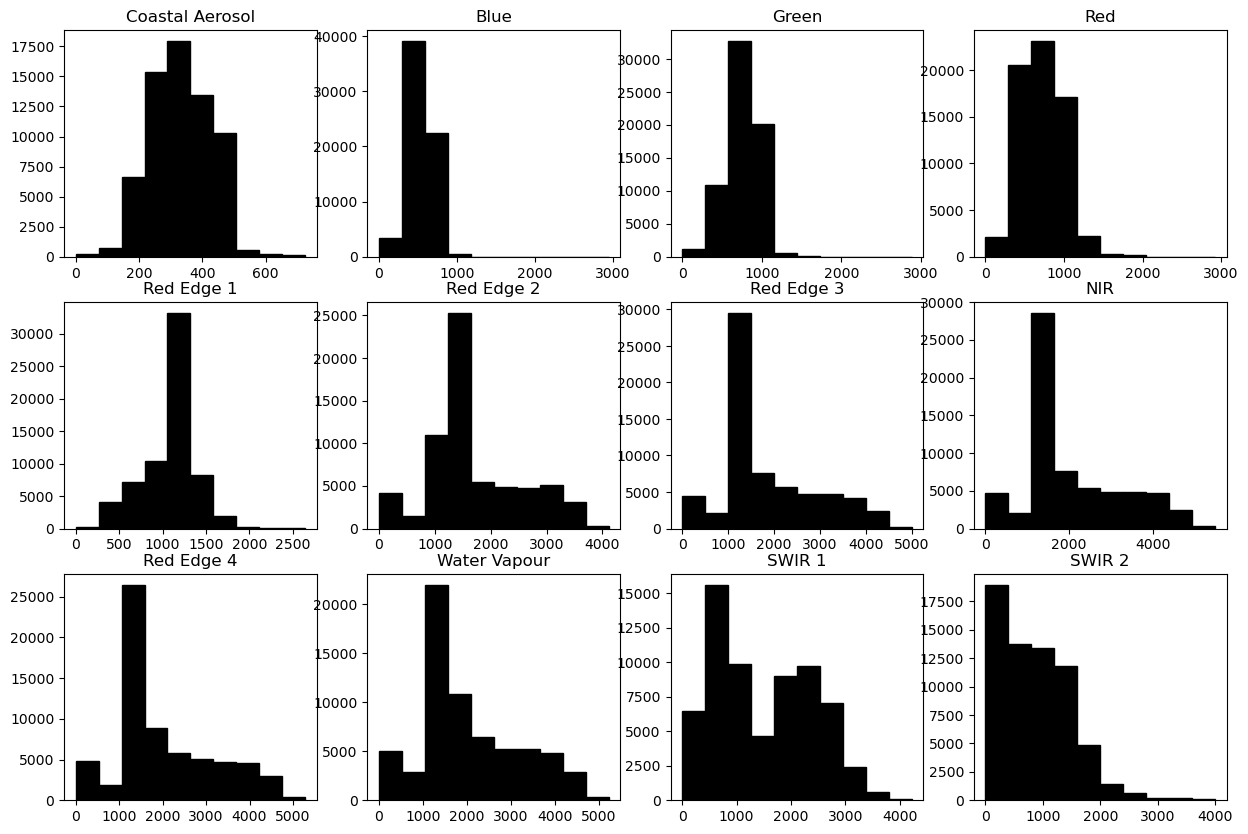

In [25]:
#Display channels from a random training image
rint = random.randint(0, len(test_input))
path = test_input[rint]
print(path)

img, rbg_img, label = load_test(path)
plot_channels(img)

band_histogram(img)

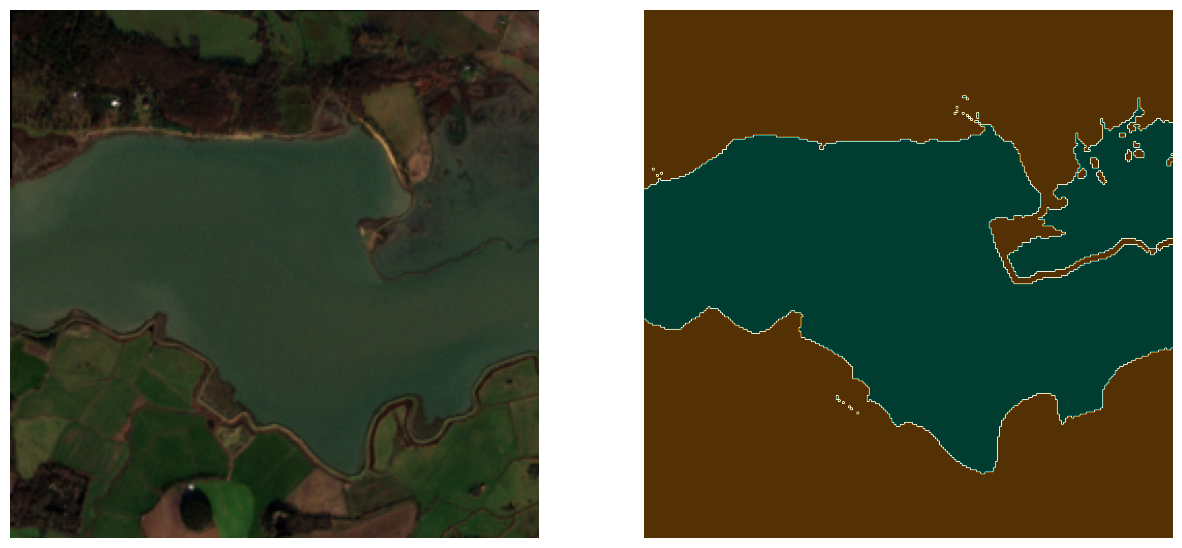

In [26]:
# Display a random test image and label
rint = random.randint(0, len(test_input))
path = test_input[rint]

plot_label(path)

In [33]:
# Tide data
tides = pd.read_csv("../data/SWED/test-set-tidal-state.csv") # I dunno where is the file
tides.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/SWED/test-set-tidal-state.csv'

In [30]:
# Order tide data by tile number field and image number
image_ID = []
for name in tides['image']: 
    s = name.split("_")
    ID = "{}_{}".format(s[5],s[9])
    image_ID.append(ID)

tides['ID'] = image_ID
tides = tides.sort_values(["ID","tide"])
tides

NameError: name 'tides' is not defined

In [32]:
#Split tide data into high and low tide
#Note: images will be in the correct order. 
#That is, the first image in high is the corresponing image in low
high = list(tides[tides.tide=='high']['image'])
low = list(tides[tides.tide=='low']['image'])

NameError: name 'tides' is not defined

In [31]:
#Display high and low tide images
path = "../../data/SWED/test/images/{}"

i = 14
img, high_rgb, label = load_test(path.format(high[i]))
img, low_rgb, label = load_test(path.format(low[i]))

fig, axs = plt.subplots(1,2,figsize=(15,15))
fig.patch.set_facecolor('xkcd:white')

axs[0].imshow(high_rgb)
axs[0].set_title("High Tide",size=20)
axs[0].axis("off")

axs[1].imshow(low_rgb)
axs[1].set_title("Low Tide",size=20)
axs[1].axis("off")

NameError: name 'high' is not defined